### In this notebook we apply `sbi` to the noise-free spectra

In [101]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import prepare_for_sbi, SNPE, SNLE, simulate_for_sbi

import matplotlib.pyplot as plt
import numpy as np

In [102]:
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [103]:
import pickle

In [163]:
## Load the NN emulator `speculator`
with open('./best_recon_err_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [164]:
def emulator(parameter_set):
    return speculator.predict_spec(parameter_set)

In [165]:
# tage and tau
lower_bounds = torch.tensor([0.1, -2])
upper_bounds = torch.tensor([13.1, 2])
prior = utils.BoxUniform(low=lower_bounds, high=upper_bounds)

In [136]:
simulator, prior = prepare_for_sbi(emulator, prior)
inference = SNPE(prior=prior, density_estimator='nsf')
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [137]:
inference = inference.append_simulations(theta, x)

In [138]:
density_estimator = inference.train()

Neural network successfully converged after 70 epochs.


In [139]:
posterior = inference.build_posterior(density_estimator)

 In order to get the distribution of theta using an ensemble of spectra, the neural density estimator should estimate the posterior conditioned on an ensemble of spectra, not on a single spectrum. But I didn't figure out how to do this using `sbi`.

In [166]:
## Test the NDE for a single spectrum, generally looks good

In [167]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [168]:
ind = 333
x_o = log_spec_all[ind]

In [169]:
samples = posterior.sample((10000,), x=x_o).detach().numpy()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

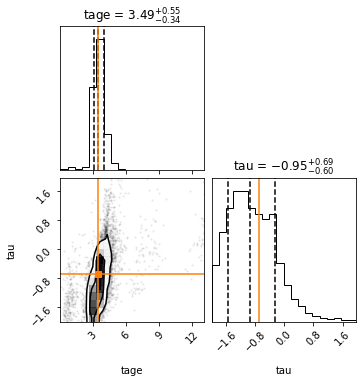

In [170]:
import corner

figure = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels=['tage', 'tau'],
                       show_titles=True, title_kwargs={"fontsize": 12})

corner.overplot_lines(figure, params[ind], color="C1")
corner.overplot_points(figure, params[ind][None], marker="s", color="C1")